# **Implementation of the HHL algorithm**
The following implementation is based on the circuit shown in the image below
<div>
<img src="img/hhl_circuit.png" width="700">
</div>

# **Import of basic libraries**

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, BasicAer, execute
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import QFT as qQFT

from scipy.linalg import expm, eig
import matplotlib.pyplot as plt
import numpy as np
import math, cmath

# **Building blocks definition**

In [2]:
def compute_t(A: np.array, clock_size: int, approximate: bool = True) -> complex:
    """
    Compute the constant t used to encode the eigenvalues using basis encoding

    Args:
        A (np.array): The matrix whose eigenvalues are to be encoded
        clock_size (int): The size of the clock register
        approximate (bool, optional): If True, approximate the ratio of the eigenvalues. Defaults to True.
    
    Returns:
        complex: The constant t
    """
    eigenvalues, _ = eig(A)
    l0, l1 = reversed(eigenvalues)
    ratio = l1 / l0
    if approximate:
        ratio = np.round(ratio)
    tl0 = 1 + 0j        # encoding of first eigenvalue 
    tl1 = ratio * tl0   # encoding of second eigenvalue

    N = 2 ** clock_size
    t1 = (2 * math.pi * tl0) / (N * l0)
    t2 = (2 * math.pi * tl1) / (N * l1)
    assert cmath.isclose(t1, t2, rel_tol=1e-06), "t1 not equal to t2"
    return t1

def QFT(circuit: QuantumCircuit, clock: QuantumRegister, do_swap: bool = False, add_swaps: bool = False):
    """
    Custom implementation of Quantum Fourier transform

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the QFT
        do_swaps (bool, optional): If set to true, swap gates in the QFT. Defaults to True.
        add_swaps (bool, optional): If set to true, add swap gates at the end of the QFT. Defaults to True.
    """
    if do_swap:
        for clock_index in range(clock.size - 1, 0, -1):
            circuit.h(clock[clock_index])
            for j in range(clock.size - clock_index - 1, -1, -1):
                circuit.cp(math.pi/math.pow(2, j + 1), clock[clock_index - 1], clock[clock_index + j])
        circuit.h(clock[0])
    else:
        for clock_index in range(1, clock.size):
            circuit.h(clock[clock_index - 1])
            for j in range(clock_index):
                circuit.cp(math.pi/math.pow(2, clock_index - j), clock[clock_index], clock[j])
        circuit.h(clock[-1])

    if add_swaps:
        for clock_index in range(int(clock.size / 2)):
                circuit.swap(clock[clock_index], clock[clock.size - clock_index - 1])

def IQFT(circuit: QuantumCircuit, clock: QuantumRegister, do_swap: bool = False, add_swaps: bool = False):
    """
    Custom implementation of Inverse Quantum Fourier transform

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the IQFT
        do_swaps (bool, optional): If set to true, swap gates in the IQFT. Defaults to True.
        add_swaps (bool, optional): If set to true, add swap gates at the beginning of the IQFT. Defaults to True.
    """
    if add_swaps:
        for clock_index in range(int(clock.size / 2)):
            circuit.swap(clock[clock_index], clock[clock.size - clock_index - 1])

    if do_swap:
        for clock_index in range(1, clock.size):
            circuit.h(clock[clock_index - 1])
            for j in range(clock_index):
                circuit.cp(-math.pi/math.pow(2, clock_index - j), clock[clock_index], clock[j])
        circuit.h(clock[-1])
    else:
        for clock_index in range(clock.size - 1, 0, -1):
            circuit.h(clock[clock_index])
            for j in range(clock.size - clock_index - 1, -1, -1):
                circuit.cp(-math.pi/math.pow(2, j + 1), clock[clock_index - 1], clock[clock_index + j])
        circuit.h(clock[0])

def QPE(circuit: QuantumCircuit, clock: QuantumRegister, input: QuantumCircuit, A: np.array, use_custom_iqft: bool = True):
    """
    Custom implementation of Quantum Phase Estimation

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the QFT
        input (QuantumRegister): The quantum register to apply the controlled-U gates
        A (np.array): The matrix to estimate its eigenvalues
        use_custom_iqft (bool, optional): If True, use the custom implementation of IQFT. Otherwise use the one defined by qiskit. 
            Defaults to True.
    """
    circuit.h(clock)

    t = compute_t(A, clock_size=clock.size)
    for i in range(clock.size):
       u = expm(1j* A * t * math.pow(2, i))
       U = add_control(UnitaryGate(u), num_ctrl_qubits=1, label=f"CU^2^{i}", ctrl_state=1)
       circuit.append(U, qargs=[clock[i], input])
       
    circuit.barrier()
   
    if use_custom_iqft:
        IQFT(circuit, clock)
    else:
        # qiskit iqft
        _qft = qQFT(clock.size, inverse=True)
        circuit.append(_qft, clock)
    
    circuit.barrier()

def IQPE(circuit: QuantumCircuit, clock: QuantumRegister, input: QuantumRegister, A: np.array, use_custom_qft: bool = True):
    """
    Custom implementation of Inverse Quantum Phase Estimation

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the QFT
        input (QuantumRegister): The quantum register to apply the controlled-U gates
        A (np.array): The matrix to estimate its eigenvalues
        use_custom_qft (bool, optional): If True, use the custom implementation of QFT. Otherwise use the one defined by qiskit. 
            Defaults to True.
    """
    if use_custom_qft:
        QFT(circuit, clock)
    else:
        # qiskit qft
        _qft = qQFT(clock.size)
        circuit.append(_qft, clock)

    circuit.barrier()

    t = compute_t(A, clock_size=clock.size)
    for i in range(clock.size - 1, -1, -1):
        u = expm(-1j* A * t * math.pow(2, i))
        U = add_control(UnitaryGate(u), num_ctrl_qubits=1, label=f"CU^-2^{i}", ctrl_state=1)
        circuit.append(U, qargs=[clock[i], input])
    
    circuit.h(clock)
    circuit.barrier()



def SWAP(circuit: QuantumCircuit, clock: QuantumRegister, barrier: bool = True):
    """
    Implement eigenvalue inversion by swapping the qubits

    The size of the clock register must be 2 or 4

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the swap
        barrier (bool, optional): If True, add a barrier. Defaults to True.
    """
    match clock.size:
        case 2:
            circuit.swap(clock[0], clock[1])
            if barrier:
                circuit.barrier()
        case 4:
            circuit.swap(clock[1], clock[3])
            if barrier:
                circuit.barrier()
        case _:
            raise ValueError(f"the size of the clock register must be 2 or 4 while the given one is {clock.size}")

def AQE(circuit: QuantumCircuit, clock: QuantumRegister, ancilla: QuantumRegister):
    """
    Custom implementation of Ancilla Quantum Encoding

    Args:
        circuit (QuantumCircuit): The quantum circuit
        clock (QuantumRegister): The quantum register to apply the swap
        input (QuantumRegister): The quantum register to apply the controlled-U gates
        ancilla (QuantumRegister): The quantum register to apply the controlled-RY gates
    """
    SWAP(circuit, clock, barrier=False)

    for clock_index in range(clock.size):
        circuit.cry(2 * math.asin(1 / 2 ** clock_index), clock[clock_index], ancilla)

    SWAP(circuit, clock, barrier=False)
    circuit.barrier()

# **Circuit definition**

In [3]:
# constants
CLOCK_SIZE = 2  # number of qbits used to encode the eigenvalues (2 or 4)
TEST_NUMBER = 1 # test number to run, 1 or 2 (1 is the one in the paper)

# test data
match TEST_NUMBER:
    case 1:
        A = 1/2 * np.matrix([[3, 1], [1, 3]])   # matrix A of the linear system to solve
        INITIAL_STATE = 1 / math.sqrt(2) * np.array([1, 1]) # initial state of the system (costant terms of the linear system)
    case 2:
        A = np.matrix([[1, -1/3], [-1/3, 1]])
        INITIAL_STATE = [0, 1]
    case _:
        raise ValueError(f"the test number must be 1 or 2 while the given one is {TEST_NUMBER}")

In [4]:
# Create the circuit
clock = QuantumRegister(CLOCK_SIZE, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
ancilla_measure = ClassicalRegister(1, name='am')
input_measure = ClassicalRegister(1, name='im')

circuit = QuantumCircuit(ancilla, clock, input, ancilla_measure, input_measure)
circuit.barrier()

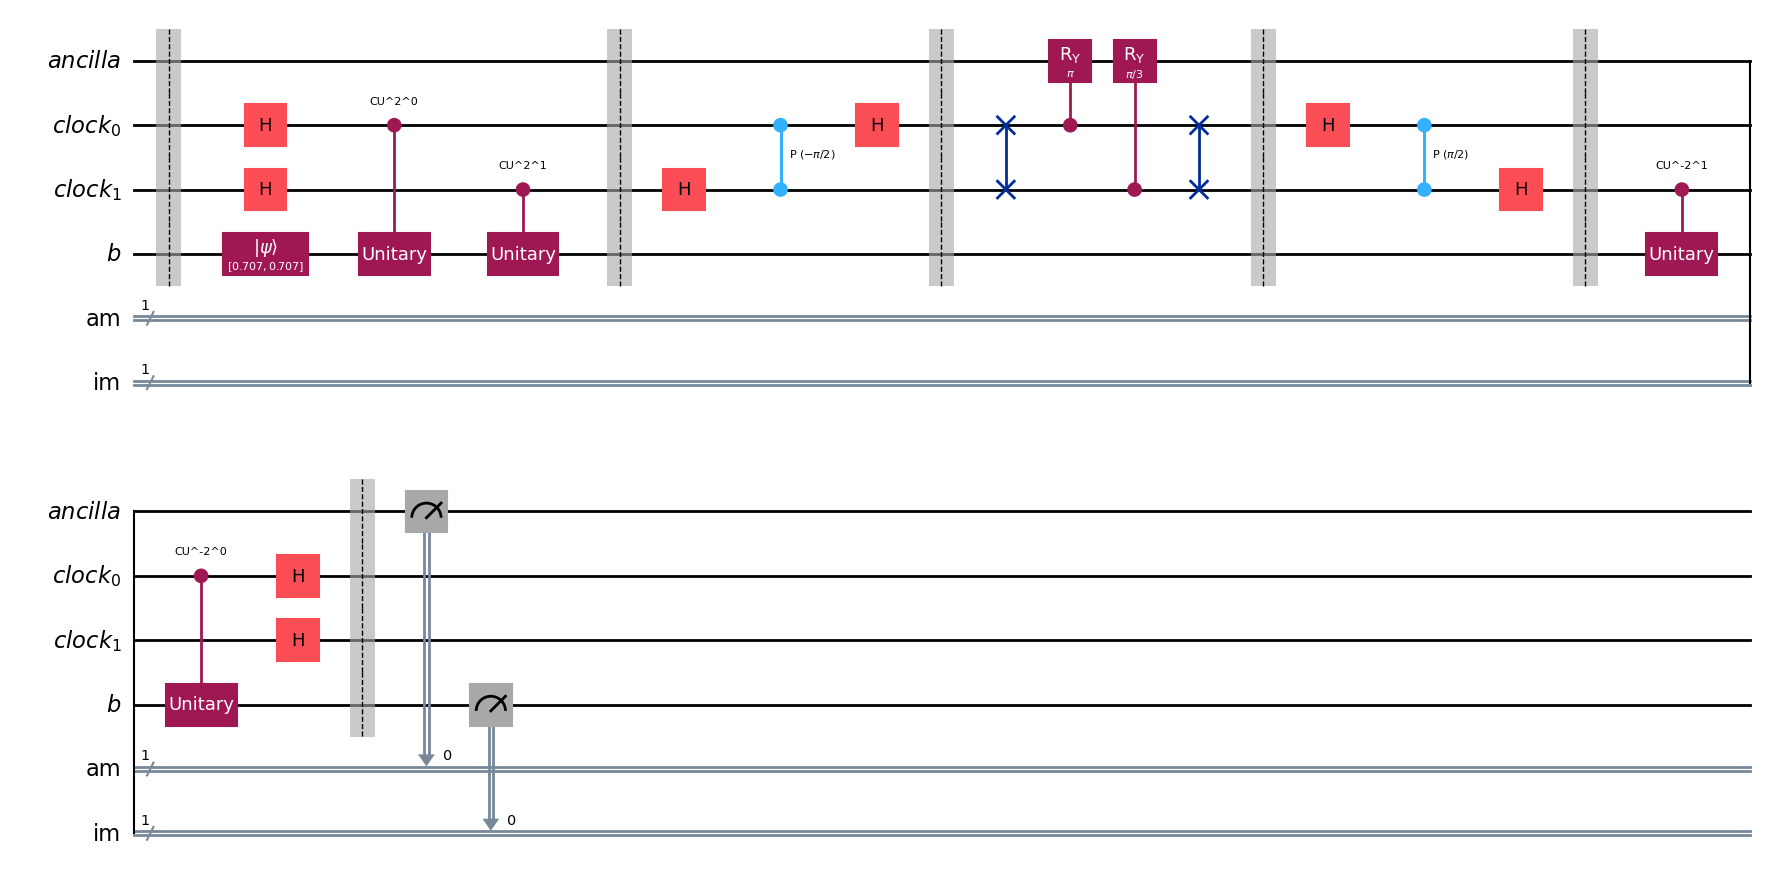

In [5]:
# Status initialization
circuit.initialize(INITIAL_STATE, ancilla.size + clock.size)

# QPE
QPE(circuit, clock, input, A)

# AQE
AQE(circuit, clock, ancilla)

# IQPE (uncomputation)
IQPE(circuit, clock, input, A)

# measure
circuit.measure(ancilla, ancilla_measure)
circuit.measure(input, input_measure)

circuit.draw(output='mpl', style="iqp")

# **Circuit execution**

In [6]:
# Execute the circuit using the simulator
shots = 20000
simulator = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=shots)

# **Results**

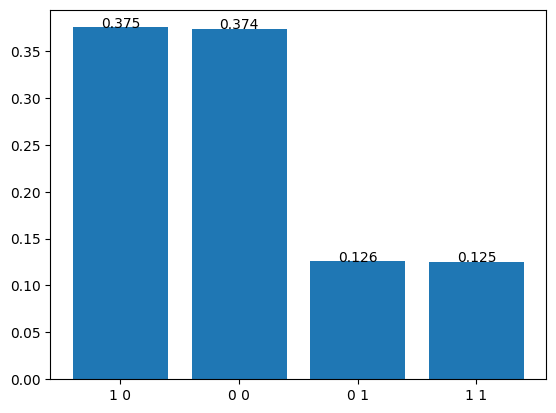

In [7]:
#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 3), ha = 'center')

# Display the results
values = np.array(list(counts.values())) / shots
plt.bar(counts.keys(), values)
addlabels(counts.keys(), values)
plt.show()

In [8]:
x = np.linalg.solve(A, INITIAL_STATE)
x1 = max(x[1], x[0])
x0 = min(x[1], x[0])
expr = x1**2 / x0**2
print(f"Expected ratio: {expr}")

ex1 = max(counts['1 1'], counts['0 1'])
ex0 = min(counts['1 1'], counts['0 1'])
estr = ex1 / ex0
print(f"Estimated ratio: {estr}")

print(f"MSE: {np.mean((estr - expr) ** 2)}")

Expected ratio: 1.0000000000000004
Estimated ratio: 1.0027932960893855
MSE: 7.802503042973844e-06
